# Guided Project: Predicting House Sale Price.

For this project we will be using the data set and predict the house sale price using Linear regression. You can read more about why the data was collected from [here.](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) and the column information from [here.](https://s3.amazonaws.com/dq-content/307/data_description.txt)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
#read the dataset
ames = pd.read_csv('AmesHousing.tsv', delimiter = '\t')

As given in the instruction we will create 3 fuctions to compute the output rmse value. The select_features() function will output only one column 'Gr Liv Area' with 'SalePrice' for the first analysis.

In [3]:
def transform_features(df):
    return df

def select_features(df):
    return df[["Gr Liv Area","SalePrice"]]    

In [4]:
def train_and_test(df2):
    #select the first 1460 rows for the train set
    train = df2.iloc[:1460,:]
    #select from 1460 row for the test data set
    test = df2.iloc[1460:,:]
    
    #select numeric columns from test and train data sets
    numeric_train = train.select_dtypes(include = ['int','float'])
    numeric_test = test.select_dtypes(include = ['int','float'])
    
    target = numeric_train['SalePrice']
    features = numeric_train.drop('SalePrice', axis = 1)
    features = features.columns
    model = LinearRegression()
    #train the model
    model.fit(train[features],target)
    test_predict = model.predict(test[features])
    mse = mean_squared_error(test_predict, test['SalePrice'])
    #get the square root value of mse for rmse
    rmse = np.sqrt(mse)
    return rmse

In [5]:
#call the transform_features() function
dataframe = transform_features(ames)
#call the select_features() function
filter_columns = select_features(dataframe)
#call the train_and_test() function
rmse_value = train_and_test(filter_columns)
print(rmse_value)

57088.25161263909


## Feature Engineering

Next we will explore further,
  1. change transform_features() to drop columns with any missing vlaues more than 5%.
  2. Text columns: drop any missing values.
  3. Numerical columns: fill any null values with most popular value for the column.
  4. create new features by combining other features.
  5. Remove any columns that leak information about the sale (e.g.year the sale happend), remove any unwanted columns.

In [6]:
ames.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


1: Drop columns with any missing value more than 5%

In [7]:
#calculate the missing values
null_values = ames.isnull().sum()
null_cols = null_values[null_values < len(ames)/20]
new_df = ames[null_cols.index]

2: Text columns : drop any missing values

In [8]:
#missing values in object type
text_null = new_df.select_dtypes(include = ['object']).isnull().sum()
null_values = text_null[text_null>0]

#drop the missing value columns from the dataframe
new_df = new_df.drop(null_values.index,axis =1)

3: Numerical columns : fill in the missing values with most popular value for the column.

In [9]:
num_df = new_df.select_dtypes(include = ['int','float'])
null_cols_2 = num_df.isnull().sum()
null_cols_2 = null_cols_2[null_cols_2 > 0]
replacement_values_dict = new_df[null_cols_2.index].mode().to_dict(orient='record')[0]
replacement_values_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [10]:
new_df = new_df.fillna(replacement_values_dict)

In [11]:
new_df.isnull().sum().any()

False

In [12]:
new_df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000


4: Create new features, creat new column with the difference from year built and year sold columns

In [13]:
years_old = new_df['Yr Sold']-new_df['Year Built']

In [14]:
years_old[years_old < 0]

2180   -1
dtype: int64

In [15]:
years_until_remod = new_df['Yr Sold'] - new_df['Year Remod/Add']

In [16]:
years_until_remod[years_until_remod<0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [17]:
new_df['Yr Old'] = years_old
new_df['Yr before remod'] = years_until_remod

5: Drop unwanted columns.

In [18]:
new_df = new_df.drop([2180,1702,2181], axis = 0)

In [19]:
new_df = new_df.drop(['Year Remod/Add','Year Built', 'Yr Sold'], axis = 1)

In [20]:
#drop columns that are not useful for ML
new_df = new_df.drop(["PID", "Order"], axis = 1)

#drop columns that leak infor about the final sale
new_df = new_df.drop(["Mo Sold", "Sale Condition", "Sale Type"], axis = 1)

In [21]:
new_df.head(3)

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Yr Old,Yr before remod
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,210,62,0,0,0,0,0,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,140,0,0,0,120,0,0,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,393,36,0,0,0,0,12500,172000,52,52


In [22]:
num_cols = new_df.select_dtypes(include = ['int','float'])
correlation = num_cols.corr()

## Correlation

We will filter the columns where correlation greater is greater than 0.4 for better view with SalePrice.

In [23]:
sorted_corr = correlation['SalePrice'].abs().sort_values(ascending = False)
sorted_corr

SalePrice          1.000000
Overall Qual       0.801206
Gr Liv Area        0.717596
Garage Cars        0.648361
Total Bsmt SF      0.644012
Garage Area        0.641425
1st Flr SF         0.635185
Yr Old             0.558979
Full Bath          0.546118
Yr before remod    0.534985
Mas Vnr Area       0.506983
TotRms AbvGrd      0.498574
Fireplaces         0.474831
BsmtFin SF 1       0.439284
Wood Deck SF       0.328183
Open Porch SF      0.316262
Half Bath          0.284871
Bsmt Full Bath     0.276258
2nd Flr SF         0.269601
Lot Area           0.267520
Bsmt Unf SF        0.182751
Bedroom AbvGr      0.143916
Enclosed Porch     0.128685
Kitchen AbvGr      0.119760
Screen Porch       0.112280
Overall Cond       0.101540
MS SubClass        0.085128
Pool Area          0.068438
Low Qual Fin SF    0.037629
Bsmt Half Bath     0.035875
3Ssn Porch         0.032268
Misc Val           0.019273
BsmtFin SF 2       0.006127
Name: SalePrice, dtype: float64

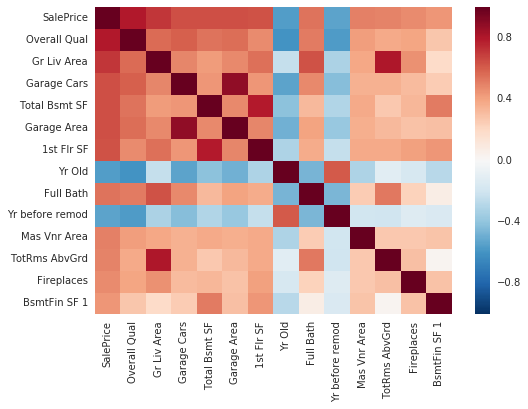

In [24]:
strong_corr = sorted_corr[sorted_corr > 0.4]
corr = new_df[strong_corr.index].corr()
sns.heatmap(corr)

From above analysis we can see that for below columns there is a high correlation with SalePrice
    * Overall Qual
    * Gr Liv Area    
    * Garage Cars
    * Total Bsmt SF
    * Garage Area 
    * 1st Flr SF   

## Feature Selection

1. Drop the columns where the correlation with 'SalePrice' is less than 0.4.

In [25]:
#drop the correlation below 0.4 columns from new_df
weak_corr = sorted_corr[sorted_corr < 0.4]
new_df = new_df.drop(weak_corr.index, axis = 1)

In [26]:
cat_cols = new_df.select_dtypes(include = ['object'])
cat_cols.head(3)

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Plywood,TA,TA,CBlock,GasA,Fa,Y,TA,Typ,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,VinylSd,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Wd Sdng,TA,TA,CBlock,GasA,TA,Y,Gd,Typ,Y


2: Text columns: drop the columns where the value counts is more than 10 to create dummies.

In [27]:
#Find the unique value_counts of the columns
unique_counts = cat_cols[cat_cols.columns].apply(lambda col:len(col.value_counts()))

In [28]:
#drop the value counts() greater than 10 from the data frame
unique_counts_high = unique_counts[unique_counts > 10].index
new_df = new_df.drop(unique_counts_high, axis = 1)

In [29]:
new_df.head(3)

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,...,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,SalePrice,Yr Old,Yr before remod
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,TA,7,Typ,2,2.0,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,...,TA,5,Typ,0,1.0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,Gd,6,Typ,0,1.0,312.0,Y,172000,52,52


3: Check the variance value of the columns

In [30]:
#check for the variance of the columns
new_df.var().sort_values()

Full Bath          3.052255e-01
Fireplaces         4.194511e-01
Garage Cars        5.778164e-01
Overall Qual       1.981361e+00
TotRms AbvGrd      2.444504e+00
Yr before remod    4.349031e+02
Yr Old             9.171194e+02
Mas Vnr Area       3.135898e+04
Garage Area        4.611403e+04
1st Flr SF         1.470394e+05
Total Bsmt SF      1.874740e+05
BsmtFin SF 1       2.022234e+05
Gr Liv Area        2.477836e+05
SalePrice          6.386267e+09
dtype: float64

4: Create dummies for the text columns.

In [31]:
txt_cols = new_df.select_dtypes(include = 'object')
for col in txt_cols:
    dummy_df = pd.get_dummies(new_df[col])
    new_df = pd.concat([new_df,dummy_df],axis = 1)
    new_df = new_df.drop(col, axis = 1)

In [32]:
new_df.head(3)

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,...,Maj2,Min1,Min2,Mod,Sal,Sev,Typ,N,P,Y
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,2.0,...,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,5,0,1.0,...,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,1.0,...,0,0,0,0,0,0,1,0,0,1


## Training and testing the model

In [33]:
#call the train_and_test function to print the rmse value
rmse_value = train_and_test(new_df)
print(rmse_value)

36623.53562910476


For the last part we will add a parameter named k that controls the type of cross validation that occur to the function train_and_test.

* When k = 0, the function will perform what we already implemented earlier and return the rmse value.
* When k = 1, the function will perform a simple cross validation. Shuffle the ordering of the rows and select and assign rows to fold one and fold two. Return the rmse value.
* When k > 0, the function will perform k-fold cross validation using k folds and compute the average rmse value and return this value.

In [34]:
def train_and_test(df, k=0):
    if k == 0:
        train = df.iloc[:1460,:]
        test = df.iloc[1460:,:]
    
        numeric_train = train.select_dtypes(include = ['int','float'])
        numeric_test = test.select_dtypes(include = ['int','float'])
    
        target = numeric_train['SalePrice']
        features = numeric_train.columns.drop('SalePrice')
        model = LinearRegression()
        model.fit(train[features],target)
        test_predict = model.predict(test[features])
        mse = mean_squared_error(test_predict, test['SalePrice'])
        rmse = np.sqrt(mse)
        
        return rmse
    
    elif k == 1:
        #shuffle the ordering of the rows in the dataframe
        shuffled_df = df.sample(frac = 1,)
        
        fold_one = shuffled_df.iloc[:1460,:].reset_index(drop = True)
        fold_two = shuffled_df.iloc[1460:,:].reset_index(drop = True)
        
        #train on fold_one and test on fold_two
        target_1 = fold_one['SalePrice']
        features_1 = fold_one.drop(['SalePrice'], axis = 1)
        features_col_1 = features_1.columns
        
        model = LinearRegression()
        model.fit(fold_one[features_col_1],target_1)
        test_predict = model.predict(fold_two[features_col_1])
        mse = mean_squared_error(test_predict, fold_two['SalePrice'])
        rmse_1 = np.sqrt(mse)
        
        #train on fold_two and test on fold_one
        target_2 = fold_two['SalePrice']
        features_2 = fold_two.drop(['SalePrice'], axis = 1)
        features_col_2 =features_2.columns
        
        model.fit(fold_two[features_col_2],target_2)
        test_predict = model.predict(fold_one[features_col_2])
        mse = mean_squared_error(test_predict, fold_one['SalePrice'])
        rmse_2 = np.sqrt(mse)
        
        rmse = np.mean([rmse_1, rmse_2])
        return rmse
    
    else:
        kf = KFold(n_splits = k, shuffle = True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train_df = df.iloc[train_index].reset_index(drop = True)
            test_df = df.iloc[test_index].reset_index(drop = True)
            
            target_3 = train_df['SalePrice']
            features_3 = train_df.drop(['SalePrice'], axis = 1)
            features_col_3 = features_3.columns
            model = LinearRegression()
            model.fit(train_df[features_col_3],target_3)
            test_predict = model.predict(test_df[features_col_3])
            mse = mean_squared_error(test_predict, test_df['SalePrice'])
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
    
    return avg_rmse

In [35]:
#test the rmse value when k = 0
rmse_value = train_and_test(new_df, k = 0)
print(rmse_value)

36623.53562910476


In [36]:
#test the rmse value when k = 1
rmse_value = train_and_test(new_df, k = 1)
print(rmse_value)

30360.566356549512


In [37]:
#check the rmse values for k> 4
rmse_values = train_and_test(new_df, k = 4)

[25415.863561625752, 25818.10265335115, 28246.471600749835, 37093.83269057713]


## Conclusion

The project was to train and test the model using linear regression to predict the house prices. The columns to train and test the model was selected under feature engineering and feature selection. Using k fold cross validation will out put the lowest rmse value while simple cross validation will also give a low output for the rmse value compared to holdout validation (k=0).